## 0. Install and Import Dependencies

In [1]:
!pip install easyocr
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=be9f3e9b9bffff836d92f27fc60c66efdc11426ef804e4c52601d7c2f3b1a85b
  Stored in directory: /home/macavins/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import easyocr

## 1. Read in Image, Grayscale and Blur

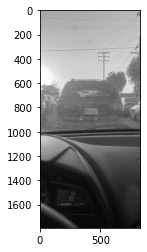

In [81]:
img = cv2.imread('plate.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

## 2. Apply filter and find edges for localization

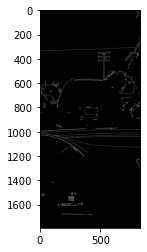

In [82]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 3. Find Contours and Apply Mask

In [83]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [84]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [85]:
location

array([[[369, 809]],

       [[468, 803]],

       [[471, 852]],

       [[375, 855]]], dtype=int32)

In [86]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

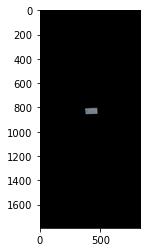

In [87]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [88]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

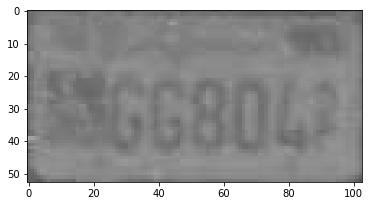

In [89]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

## 4. Use Easy OCR To Read Text

In [90]:
reader = easyocr.Reader(['en'])
result = reader.readtext(cropped_image)
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[10, 18], [100, 18], [100, 50], [10, 50]], '3668042', 0.06507059246541744)]

## 5. Render Result

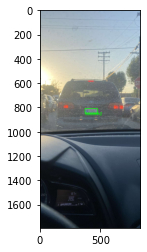

In [91]:
text = result[0][-2]
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))